© Alexander Jüstel, Department for Computational Geosciences and Reservoir Engineering, RWTH Aachen University,
GNU Lesser General Public License v3.0

# Model 3 - Faulted Layers

Learning outcome of this tutorial:
- How to import prepared input data into `GemPy` via CSV-Files
- How to build a simple model consisting of faulted layers (graben structure) belonging to one Series
- How to visualize the resulting model with cross sections in 2D and the entire model in 3D

This notebook illustrates how to create a simple model of faulted layers, here representing a graben structure, in `GemPy`. The input data is provided as CSV-files. The first file contains the interface points, the boundaries between stratigraphic units as well as the interface points of the faults. The second file contains the orientation of the layers and the faults. During the setup of the model, we will define that all layers belong to one so-called `Series`. Per definition, only orientations for one layer are necessary to compute the model. However, it is of course possible to provide orientation measurements for the other layers as well. Each of the two faults will be added as separate `Series` to the models. 

![model3](images/model3.png)

# Installing GemPy

If have not installed `GemPy` yet, please follow the installation instructions at https://docs.gempy.org/installation.html. If you encounter any issues, feel free to open a discussion at https://github.com/cgre-aachen/gempy/discussions. There, the `GemPy` development team will help you out. 

# Importing Libraries

For this notebook, we only need the `pandas` library and of course the `GemPy` library. Any warnings that may appear can be ignored for now. 

In [1]:
import pandas as pd
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Importing Interface Points

We are using `pandas` to load the interface points that were prepared beforehand and stored as CSV-file. The only information that is needed are the location of the interface point (`X`, `Y`, `Z`) and the `formation` it belongs to. 

In [2]:
interfaces = pd.read_csv('../data/model3/model3_interfaces.csv', 
                         delimiter = ';')
interfaces.head()

,X,Y,Z,formation
0,200,250,-100,Layer1
1,200,500,-100,Layer1
2,200,750,-100,Layer1
3,200,250,-200,Layer2
4,200,500,-200,Layer2


# Importing Orientations

The orientations will also be loaded using `pandas`. In addition to the location and the formation the orientation belongs to, the dip value, azimuth value (dip direction) and a polarity value (mostly set to 1 by default) needs to be provided. As the model will feature horizontal layers, the dip is equal to 0. In addition, we added orientations belonging to the faults to constrain the model. 

In [3]:
orientations = pd.read_csv('../data/model3/model3_orientations.csv', 
                           delimiter=';')
orientations.head()

,X,Y,Z,formation,dip,azimuth,polarity
0,200,500,-100,Layer1,0,0,1
1,800,500,-100,Layer1,0,0,1
2,500,500,-300,Layer1,0,0,1
3,250,500,-100,Fault1,60,90,1
4,750,500,-100,Fault2,60,270,1


# Creating the GemPy Model

The first step is to create a new empty `GemPy` model. 

In [4]:
geo_model = gp.create_model('Model3_Faulted_Layers')
geo_model

Model3_Faulted_Layers  2022-04-02 14:34

# Data Initiation

During this step, the extent of the model (`xmin`, `xmax`, `ymin`, `ymax`, `zmin`, `zmax`) and the resolution in `X`, `Y`and `Z` direction (equals the number of cells in each direction) will be set using lists of values. The interface points and orientations will be passed as `pandas` `DataFrames`. 

In [5]:
gp.init_data(geo_model=geo_model, 
             extent=[0, 1000, 0, 1000, -600, 0], 
             resolution=[100, 100, 100],
             surface_points_df=interfaces,
             orientations_df=orientations,
             default_values=True)

Active grids: ['regular']


Model3_Faulted_Layers  2022-04-02 14:34

# Inspecting the Surfaces

The model consists of four different layers or surfaces now which all belong to the `Default series`. During the next step, the proper `Series` will be assigned to the surfaces.

In [6]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Layer1,Default series,1,#015482,1
1,Layer2,Default series,2,#9f0052,2
2,Layer3,Default series,3,#ffbe00,3
3,Fault1,Default series,4,#728f02,4
4,Fault2,Default series,5,#443988,5


# Assigning the Series

During this step, all three layers of the model are assigned to the `Strata1` series. Therefore, we only need orientations that belong to `Layer1` to be able to calculate the remaining surfaces. In addition, we define two `Series` containing the two faults. We will also add a `Basement` here. In order for `GemPy` to recognize the faults as faults, we need to define them as faults (`set_is_fault`). 

In [7]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Fault1': ('Fault1'),
                          'Fault2': ('Fault2'),
                          'Strata1': ('Layer1', 'Layer2', 'Layer3'),                          
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')
geo_model.set_is_fault(['Fault1', 'Fault2'])
geo_model.surfaces

Fault colors changed. If you do not like this behavior, set change_color to False.


,surface,series,order_surfaces,color,id
3,Fault1,Fault1,1,#527682,1
4,Fault2,Fault2,1,#527682,2
0,Layer1,Strata1,1,#ffbe00,3
1,Layer2,Strata1,2,#728f02,4
2,Layer3,Strata1,3,#443988,5
5,Basement,Strata1,4,#ff3f20,6


# Plotting the input data in 2D using Matplotlib

The input data can now be visualized in 2D using `matplotlib`.

C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


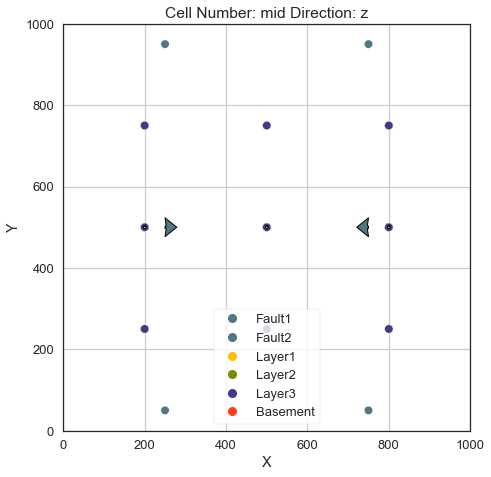

In [8]:
import matplotlib.pyplot as plt
gp.plot_2d(geo_model, 
           direction='z', 
           show_lith=False, 
           show_boundaries=False)
plt.grid()

# Plotting the input data in 3D using PyVista

The input data can also be viszualized using the `pyvista` package. In this view, the interface points are visible as well as the orientations (marked as arrows) which indicate the normals of each orientation value. 

C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\pyvista\utilities\helpers.py:476: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


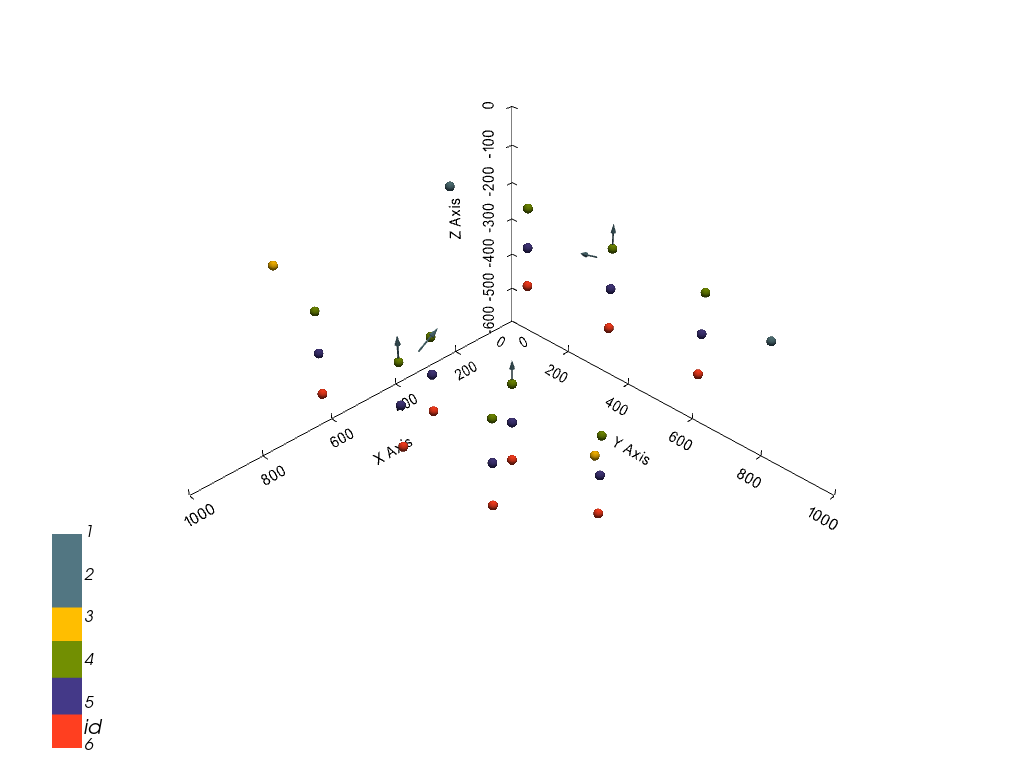

In [9]:
gp.plot_3d(geo_model, 
           image=False, 
           plotter_type='basic', 
           notebook=True)

# Setting the interpolator

Setting the interpolator is necessary before computing the actual model. Here, the most important kriging parameters can be defined. 

In [10]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                       values
range             1536.22915
$C_o$            56190.47619
drift equations    [3, 3, 3]


# Computing the model

In [11]:
sol = gp.compute_model(geo_model, 
                       compute_mesh=True)

# Visulazing Cross Sections of the computed model

Cross sections in different directions and at different cell numbers can be displayed. Here, we only see the horizontal layers of the model. Not very much exciting yet. 

C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


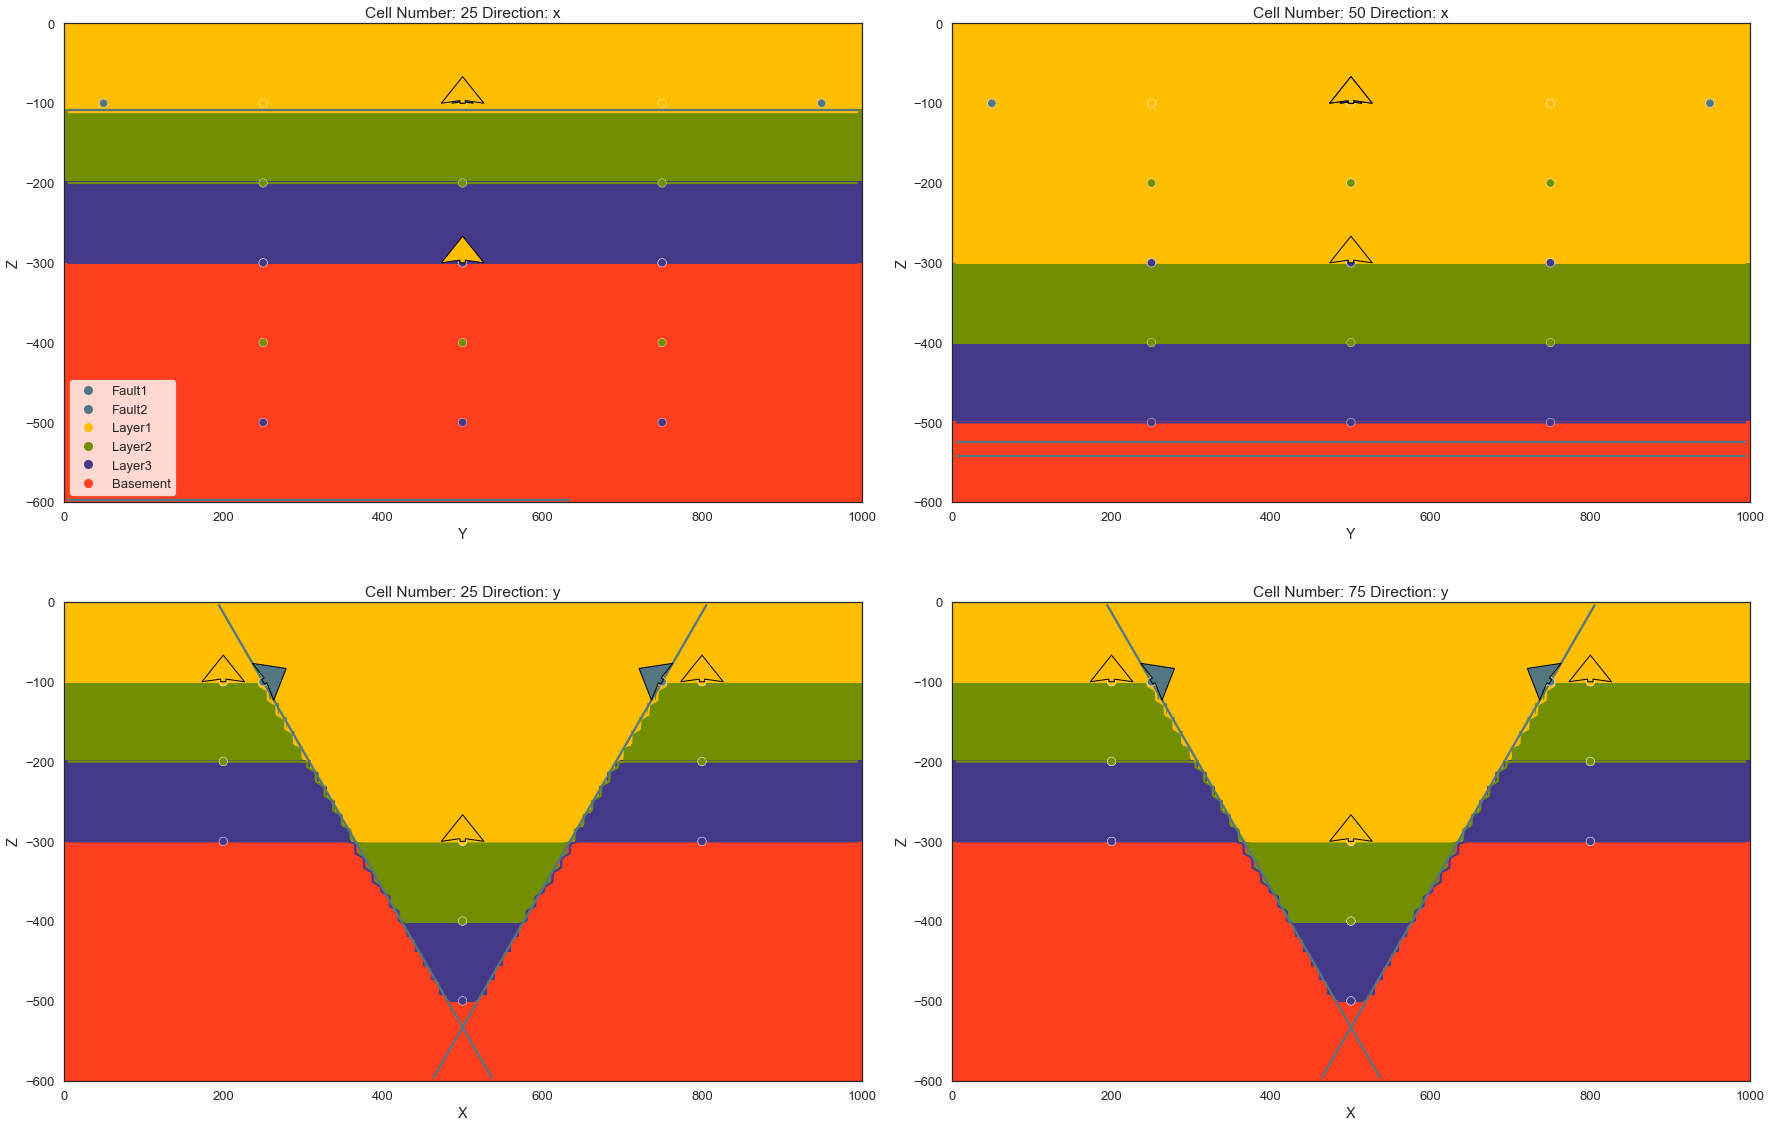

In [12]:
gp.plot_2d(geo_model, 
           direction=['x', 'x', 'y', 'y'], 
           cell_number=[25, 50, 25, 75], 
           show_topography=False, 
           show_data=True)

# Visualizing the computed model in 3D

The computed model can be visualized in 3D using the `pyvista` library. Setting `notebook=False` will open an interactive windows and the model can be rotated and zooming is possible. 

C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\pyvista\plotting\plotting.py:1948: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\pyvista\utilities\helpers.py:476: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


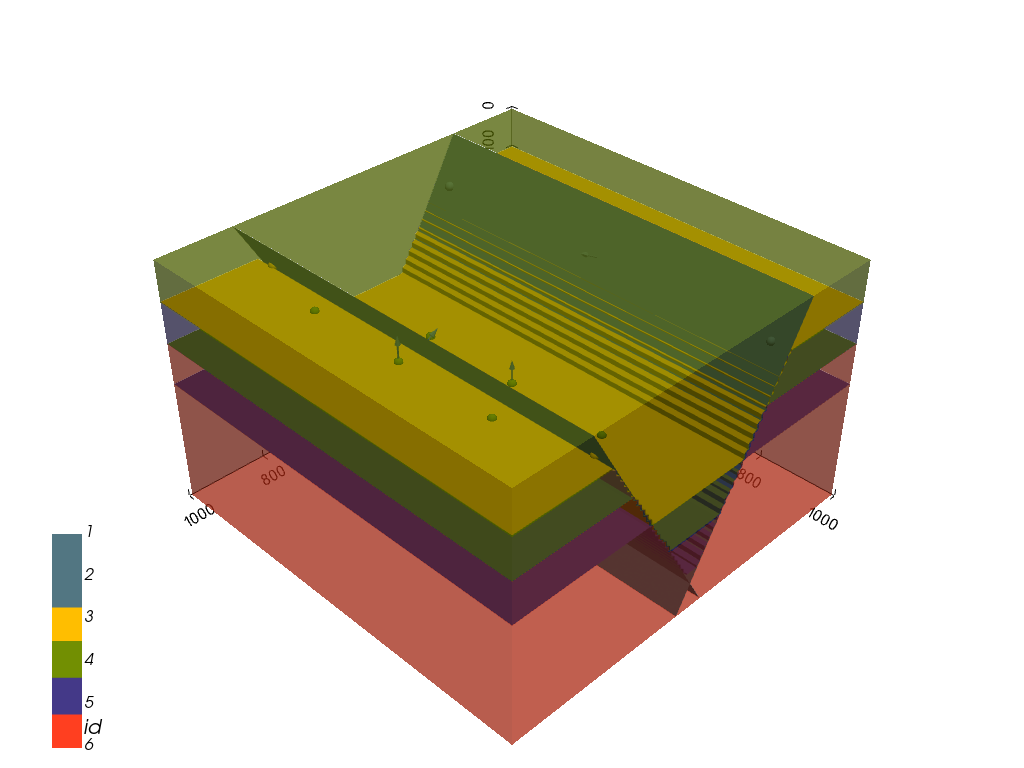

In [13]:
gpv = gp.plot_3d(geo_model, 
                 image=False, 
                 show_topography=True,
                 plotter_type='basic', 
                 notebook=True, 
                 show_lith=True)

# Conclusions

In this notebook, the user learnt:
- How to import prepared input data into `GemPy` via CSV-Files
- How to build a simple model consisting of faulted layers belonging to one Series
- How to visualize the resulting model with cross sections in 2D and the entire model in 3D


# Outlook

In the next notebook, the user will learn:
- How to create a model consisting of truncated layers